<a href="https://colab.research.google.com/github/dothihong14/BTL_AI_Nhom9/blob/main/Copy_of_Acne1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Khai báo thư viện
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imutils import paths
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/acne_level'

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Tạo thư mục cha train, val, test
train_dir = '/content/drive/MyDrive/Acne_level/acne_train'
val_dir = '/content/drive/MyDrive/Acne_level/acne_val'
test_dir = '/content/drive/MyDrive/Acne_level/acne_test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Duyệt qua từng thư mục con trong thư mục chứa dữ liệu
for level_folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, level_folder)):
        level_dir = os.path.join(data_dir, level_folder)

        # Tạo các thư mục level 0, level 1, level 2 trong train, val, test
        train_level_dir = os.path.join(train_dir, level_folder)
        val_level_dir = os.path.join(val_dir, level_folder)
        test_level_dir = os.path.join(test_dir, level_folder)

        os.makedirs(train_level_dir, exist_ok=True)
        os.makedirs(val_level_dir, exist_ok=True)
        os.makedirs(test_level_dir, exist_ok=True)

        # Lấy danh sách tất cả các tệp trong thư mục cấp độ hiện tại
        all_files = [os.path.join(level_dir, f) for f in os.listdir(level_dir) if os.path.isfile(os.path.join(level_dir, f))]

        # Chia dữ liệu thành train và temp với tỷ lệ 70%-30%
        train_files, temp_files = train_test_split(all_files, test_size=0.2, random_state=42)

        # Chia tiếp dữ liệu temp thành validation và test với tỷ lệ 50%-50% (tương đương 15%-15% của tổng dữ liệu ban đầu)
        val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

        # Hàm để di chuyển tệp vào thư mục đích
        def move_files(file_list, destination_folder):
            for file in file_list:
                shutil.copy(file, os.path.join(destination_folder, os.path.basename(file)))

        # Di chuyển các tệp vào thư mục tương ứng trong train, val, test
        move_files(train_files, train_level_dir)
        move_files(val_files, val_level_dir)
        move_files(test_files, test_level_dir)

In [ ]:

from imutils import paths
imgAcne= list(paths.list_images("/content/drive/MyDrive/Acne_level"))
imgTrain = list(paths.list_images("/content/drive/MyDrive/Acne_level/acne_train"))
imgVali = list(paths.list_images("/content/drive/MyDrive/Acne_level/acne_val"))
imgTest = list(paths.list_images("/content/drive/MyDrive/Acne_level/acne_test"))
print(f"Number of Acne images: {len(imgAcne)}")
print(f"Number of Train images: {len(imgTrain)}")
print(f"Number of Vali images: {len(imgVali)}")
print(f"Number of Test images: {len(imgTest)}")

Number of Acne images: 1261
Number of Train images: 1007
Number of Vali images: 126
Number of Test images: 128


# **XÂY DỰNG MÔ HÌNH**

In [ ]:
#Tiền xử lý hình ảnh cho toàn bộ tập dữ liệu
def preprocess_image(imgAcne):
  for image, label in imgAcne:
    imgAcne = cv2.imread(image)
    #Chuyển đổi ảnh sang định dạng RGB
    imgAcne = cv2.cvtColor(imgAcne, cv2.COLOR_BGR2RGB)
    #Điều chỉnh kích thước ảnh
    imgAcne = cv2.resize(imgAcne, (150, 150))
    #Tăng cường hình ảnh
    imgAcne = augment_image(imgAcne)
    yield imgAcne, label

**Tập huấn luyện (Train)**

In [ ]:
X_train_acne = []
y_train_acne = []

In [ ]:
#Xử lý hình ảnh tập huấn luyện (Train)
for path_train in imgTrain:

	Y_train_acne = path_train.split(os.path.sep)[-2]

	# Xu ly anh
	img_acne = cv2.imread(path_train)
	img_acne = cv2.cvtColor(img_acne, cv2.COLOR_BGR2RGB) #Chuyển đổi ảnh sang định dạng RGB
	img_acne = cv2.resize(img_acne, (150, 150))

	# Them vao du lieu data va label
	X_train_acne.append(img_acne)
	y_train_acne.append(Y_train_acne)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

X_train_acne = np.array(X_train_acne)
y_train_acne = np.array(y_train_acne)

y_train_acne = lb.fit_transform(y_train_acne)           #Chuyển đổi nhãn thành one-hot encoding
X_train_acne = X_train_acne.astype('float32') / 255     #Chuẩn hóa dữ liệu ảnh

In [ ]:
X_test_acne = []
y_test_acne = []

**Tập validation**

In [ ]:
#Xử lý hình ảnh tập validation
for path_test in imgVali:

	Y_test_acne = path_test.split(os.path.sep)[-2]

	# Xu ly anh
	img1_acne = cv2.imread(path_test)
	img1_acne = cv2.cvtColor(img1_acne, cv2.COLOR_BGR2RGB) #Chuyển đổi ảnh sang định dạng RGB
	img1_acne = cv2.resize(img1_acne, (150, 150))

	# Them vao du lieu data va label
	X_test_acne.append(img1_acne)
	y_test_acne.append(Y_test_acne)

In [ ]:
X_test_acne = np.array(X_test_acne)
y_test_acne = np.array(y_test_acne)
y_test_acne = lb.fit_transform(y_test_acne)           ##Chuyển đổi nhãn thành one-hot encoding
X_test_acne = X_test_acne.astype('float32') / 255     #Chuẩn hóa dữ liệu ảnh

In [ ]:
#Xử lý tập huấn luyện
train_generator = preprocess_image(imgTrain)
#Xứ lý tập xác nhận
val_generator = preprocess_image(imgVali)
#Xử lý tập đánh giá
test_generator = preprocess_image(imgTest)

# **Huấn luyện mô hình**

In [ ]:
model = Sequential([
    #Lớp CNN1
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), # Lớp tích chập 2D, 32 bộ lọc kích thước 3 x 3, hàm kích hoạt là ReLU
                                                                          # kích thước ảnh đầu vào 150x150 với 3 kênh màu
    MaxPooling2D(2,2), # Lớp MaxPooling 2D kích thước 2x2 dùng để giảm kích thước và số lượng đặc trưng thông qua lấy giá trị lớn nhất trong mỗi vùng pool.
    #Lớp CNN2
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(2,2),
    #Lớp CNN3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(), # chuyển đổi đầu ra từ tensor nhiều chiều thành một vector 1D.
    Dense(128, activation = 'relu'), # Lớp kết nối đầy đủ với 128 đơn vị và hàm kích hoạt là ReLU
    Dense(3, activation = 'softmax') # phân loại đối tượng vào 3 lớp khác nhau, hàm softmax để tạo phân phối xác suất trên các lớp
])

In [ ]:
#Biên dịch mô hình
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Kiến trúc mô hình
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
# Huấn luyện mô hình
Epochs = 15
history = model.fit(
  X_train_acne, y_train_acne,
  validation_data = (X_test_acne, y_test_acne),
  epochs = Epochs,
  batch_size = 32)

Epoch 1/15
32/32 [==============================] - 56s 2s/step - loss: 1.0306 - accuracy: 0.4578 - val_loss: 0.9872 - val_accuracy: 0.4524
Epoch 2/15
32/32 [==============================] - 56s 2s/step - loss: 0.9724 - accuracy: 0.5094 - val_loss: 0.9922 - val_accuracy: 0.5238
Epoch 3/15
32/32 [==============================] - 51s 2s/step - loss: 0.9443 - accuracy: 0.5283 - val_loss: 0.9857 - val_accuracy: 0.4603
Epoch 4/15
32/32 [==============================] - 53s 2s/step - loss: 0.9140 - accuracy: 0.5601 - val_loss: 1.0077 - val_accuracy: 0.4603
Epoch 5/15
32/32 [==============================] - 52s 2s/step - loss: 0.8777 - accuracy: 0.5760 - val_loss: 1.0213 - val_accuracy: 0.5317
Epoch 6/15
32/32 [==============================] - 54s 2s/step - loss: 0.8132 - accuracy: 0.6256 - val_loss: 1.0091 - val_accuracy: 0.4841
Epoch 7/15
32/32 [==============================] - 52s 2s/step - loss: 0.7265 - accuracy: 0.6753 - val_loss: 1.1409 - val_accuracy: 0.5000
Epoch 8/15
32/32 [==

# **ĐÁNH GIÁ MÔ HÌNH**

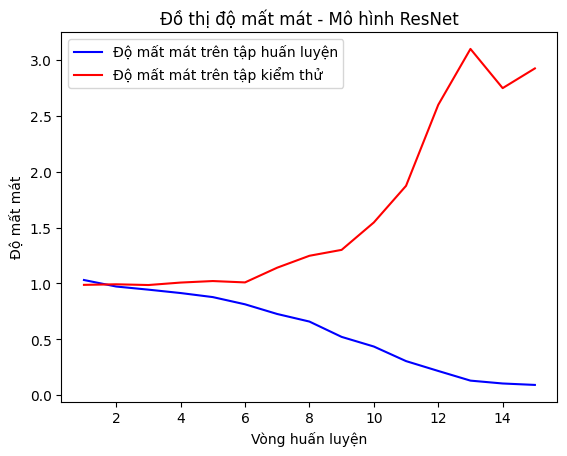

In [ ]:
# Đồ thị hàm mất mát
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label = 'Độ mất mát trên tập huấn luyện')
plt.plot(epochs, val_loss, 'r'
, label = 'Độ mất mát trên tập kiểm thử')
plt.title('Đồ thị độ mất mát - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ mất mát')
plt.legend()
plt.show()

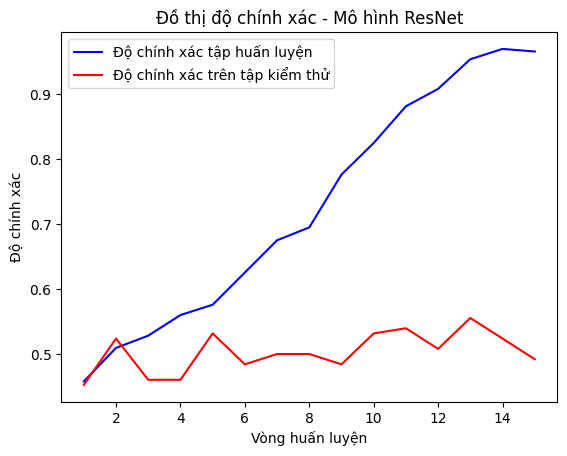

In [ ]:
# Đồ thị độ chính xác của mô hình
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label = 'Độ chính xác tập huấn luyện')
plt.plot(epochs, val_acc, 'r', label = 'Độ chính xác trên tập kiểm thử')
plt.title('Đồ thị độ chính xác - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ chính xác')
plt.legend()
plt.show()

In [ ]:
#
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer

# Bước 1: Huấn luyện mô hình
# Bước 2: Dự đoán trên tập kiểm tra
y_pred_probs = model.predict(X_test_acne)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Nếu y_test_acne đã ở định dạng one-hot encoding, chuyển đổi nó thành dạng nhãn đơn
if y_test_acne.ndim == 2:
    y_test_acne = np.argmax(y_test_acne, axis=1)

# Bước 3: Tính toán F1-score
f1_macro = f1_score(y_test_acne, y_pred_classes, average='macro')
f1_micro = f1_score(y_test_acne, y_pred_classes, average='micro')
f1_weighted = f1_score(y_test_acne, y_pred_classes, average='weighted')

print(f"F1-score (macro): {f1_macro}")
print(f"F1-score (micro): {f1_micro}")
print(f"F1-score (weighted): {f1_weighted}")

4/4 [==============================] - 3s 705ms/step
F1-score (macro): 0.38380171955489556
F1-score (micro): 0.49206349206349204
F1-score (weighted): 0.4714834805578907


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test_acne)
y_pred_classes = np.argmax(y_pred, axis=1)

# Kiểm tra và điều chỉnh y_test_acne nếu cần
if y_test_acne.ndim == 1:
    # Nếu y_test_acne là một vector, điều chỉnh hoặc xử lý nó sao cho phù hợp
    y_true_classes = y_test_acne  # Hoặc thực hiện các thao tác phù hợp khác
else:
    y_true_classes = np.argmax(y_test_acne, axis=1)

# In báo cáo phân loại
print(classification_report(y_true_classes, y_pred_classes, target_names=['Level 0', 'Level 1', 'Level 2']))

# Tính toán các chỉ số
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# In các chỉ số
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
print('Accuracy:', accuracy)


4/4 [==============================] - 2s 359ms/step
              precision    recall  f1-score   support

     Level 0       0.53      0.57      0.55        56
     Level 1       0.48      0.55      0.51        53
     Level 2       0.20      0.06      0.09        17

    accuracy                           0.49       126
   macro avg       0.40      0.39      0.38       126
weighted avg       0.46      0.49      0.47       126

Precision: 0.46399514268366726
Recall: 0.49206349206349204
F1-Score: 0.4714834805578907
Accuracy: 0.49206349206349204


In [ ]:
model.save('/content/drive/MyDrive/acne/CNN_ACNE.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **KIỂM THỬ HÌNH ẢNH**

In [ ]:
from imutils import paths

imgTest = list(paths.list_images("/content/drive/MyDrive/Acne_level/acne_test"))

In [ ]:
X_testHA = []
y_testHA = []

In [ ]:
for path_test in imgTest:
    Y_testHA = path_test.split(os.path.sep)[-2]

    # Xu ly anh
    img1 = cv2.imread(path_test)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img1, (150, 150))

    if img1 is None:
        print("Lỗi: Không thể đọc hình ảnh từ đường dẫn:", path_test)
        continue

    img1 = cv2.resize(img1, (150, 150))

    # Thêm vào dữ liệu data và label
    X_testHA.append(img1)
    y_testHA.append(Y_testHA)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
X_testHA = np.array(X_testHA)
y_testHA = np.array(y_testHA)
y_testHA = lb.fit_transform(y_testHA)
X_testHA = X_testHA.astype('float32') / 255

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/acne_level/CNN_ACNE.h5')

In [ ]:
y_pred = loaded_model.predict(X_testHA)

4/4 [==============================] - 3s 662ms/step


In [ ]:
y_pred

array([[4.42788512e-01, 5.57211518e-01, 1.80555091e-08],
       [8.90407711e-04, 5.36435902e-01, 4.62673634e-01],
       [6.38100922e-01, 3.61133188e-01, 7.65937963e-04],
       [9.22210336e-01, 5.95700592e-02, 1.82196405e-02],
       [9.70232904e-01, 2.08197907e-02, 8.94726999e-03],
       [9.86781120e-01, 1.23498188e-02, 8.68977048e-04],
       [2.18268018e-02, 6.23228550e-01, 3.54944736e-01],
       [7.95696974e-01, 2.01179221e-01, 3.12388781e-03],
       [9.51431096e-01, 3.16823088e-02, 1.68865658e-02],
       [7.16777563e-01, 2.83222258e-01, 1.00544625e-07],
       [7.39692943e-03, 8.75624061e-01, 1.16979040e-01],
       [8.93485188e-01, 7.67306909e-02, 2.97839604e-02],
       [1.68547867e-05, 9.99983132e-01, 4.91975627e-10],
       [2.50000048e-05, 6.39009118e-01, 3.60965788e-01],
       [8.68513823e-01, 2.70229485e-03, 1.28783926e-01],
       [3.61898243e-01, 6.38081908e-01, 1.97721511e-05],
       [8.35286200e-01, 1.64295167e-01, 4.18581476e-04],
       [7.31081903e-01, 2.67775

In [ ]:
max_indices = np.argmax(y_pred, axis=1)

In [ ]:
y_pred_new = np.zeros_like(max_indices)
y_pred_new[max_indices == 1] = 1
y_pred_new[max_indices == 2] = 2

In [ ]:
y_pred_new

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 2, 2, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0,
       2, 1, 1, 2, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1,
       0, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 1, 1, 1, 2, 0,
       0, 0, 1, 1, 1, 0, 2, 2, 1, 1, 2, 0, 1, 1, 0, 1, 0, 1])

In [ ]:
y_test_new = np.array(y_testHA).reshape(-1)

# In kết quả
print(y_test_new)

[1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1
 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0
 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1
 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1
 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0
 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1
 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0
 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 1]


**KIỂM THỬ HÌNH ẢNH CỤ THỂ**

In [ ]:
labels = ['Level 0','Level 1','Level 2']

In [ ]:
import cv2

# Đường dẫn tới tệp ảnh JPEG
img_path = '/content/drive/MyDrive/Acne_level/acne_test/Level 1/levle1_120.jpg'

# Đọc ảnh từ đường dẫn
img = cv2.imread(img_path)

# Kiểm tra xem ảnh có được đọc thành công không
if img is None:
    print(f"Không thể đọc được ảnh từ đường dẫn: {img_path}")
else:
    print(f"Đã đọc thành công ảnh từ đường dẫn: {img_path}")

Đã đọc thành công ảnh từ đường dẫn: /content/drive/MyDrive/Acne_level/acne_test/Level 1/levle1_120.jpg


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Đọc ảnh và chuyển ảnh
img = cv2.imread('/content/drive/MyDrive/Acne_level/acne_test/Level 1/levle1_120.jpg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Đổi kích thước ảnh về 150x150
img_resize = cv2.resize(img_color, (150, 150))

# Thêm một chiều để khớp với đầu vào của mô hình và chuẩn hóa giá trị pixel về khoảng [0, 1]
img_resize = img_resize / 255.0
img_resize = np.expand_dims(img_resize, axis=-1)  # Thêm chiều kênh
img_resize = np.expand_dims(img_resize, axis=0)  # Thêm chiều batch

# Tải mô hình đã huấn luyện (thay 'loaded_model' bằng tên mô hình của bạn)
model_path = "/content/drive/MyDrive/acne/CNN_ACNE.h5"
loaded_model = tf.keras.models.load_model(model_path)

# Dự đoán
yhat = loaded_model.predict(img_resize)
max_index = np.argmax(yhat)
labels = ['Level 0', 'Level 1', 'Level 2']  # Đảm bảo rằng các nhãn được định nghĩa trước

# In kết quả
print(yhat)
print('- Level 0: ', round(yhat[0][0]*100,2), "%")
print('- Level 1: ', round(yhat[0][1]*100,2), "%")
print('- Level 2: ', round(yhat[0][2]*100,2), "%")
print("--> Nhãn dự đoán: ", labels[max_index])

# Hiển thị hình
plt.imshow(img_color)
plt.title("Hình ảnh")
plt.axis('off')
plt.show()

In [ ]:
!pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

st.title('Ứng dụng Dự đoán cấp độ mụn')

# Upload ảnh từ thiết bị
uploaded_file = st.file_uploader("Chọn một tệp hình ảnh", type=['jpg', 'jpeg'])

if uploaded_file is not None:
    # Đọc và hiển thị ảnh
    image = plt.imread(uploaded_file)
    st.image(image, caption='Ảnh đã chọn', use_column_width=True)

    # Xử lý ảnh như trong đoạn mã ban đầu
    img_color = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)  # Chuyển sang RGB nếu cần thiết
    img_resize = cv2.resize(img_color, (150, 150))
    img_resize = img_resize / 255.0
    img_resize = np.expand_dims(img_resize, axis=-1)
    img_resize = np.expand_dims(img_resize, axis=0)

    model_path = "/content/drive/MyDrive/acne_level/CNN_ACNE.h5"  # Đường dẫn tới mô hình
    loaded_model = tf.keras.models.load_model(model_path)

    yhat = loaded_model.predict(img_resize)
    max_index = np.argmax(yhat)
    labels = ['Level 0', 'Level 1', 'Level 2']

    st.write("Dự đoán:")
    st.write('- Level 0:', round(yhat[0][0] * 100, 2), "%")
    st.write('- Level 1:', round(yhat[0][1] * 100, 2), "%")
    st.write('- Level 2:', round(yhat[0][2] * 100, 2), "%")
    st.write("Nhãn dự đoán:", labels[max_index])


Writing app.py


In [ ]:
from pyngrok import ngrok

In [ ]:
# Khởi động Streamlit server
!streamlit run app.py &




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.237.210.195:8501



In [ ]:
# Tạo URL công khai với pyngrok
public_url = ngrok.connect(port='8501')
public_url
